In [6]:
system("conda install -y r-terra=1.2_10")

In [7]:
system("conda install -y r-sf=0.9_8")

In [ ]:
system("conda install -y r-gridExtra=2.3")

Warning message:
“package ‘terra’ was built under R version 4.0.5”
terra version 1.2.10


Attaching package: ‘dplyr’


The following objects are masked from ‘package:terra’:

    intersect, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘gridExtra’ was built under R version 4.0.5”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




[1] "go"
[1] "go"
[1] "go"
[1] "go"
[1] "go"
[1] "go"
[1] "df"


   user  system elapsed 
  8.498  20.001  28.584 

Reading layer `asd-shapefile-EPSG6932' from data source `/data/jwd02f/pulsar_staging/80360286/working/jupyter/asd/asd-shapefile-EPSG6932.shp' using driver `ESRI Shapefile'


Warning message:
“unhandled axis direction: "North along 90 deg East" (GDAL error 1)”


Simple feature collection with 19 features and 16 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -3348556 ymin: -3329339 xmax: 4815055 ymax: 4371127
CRS:           NA


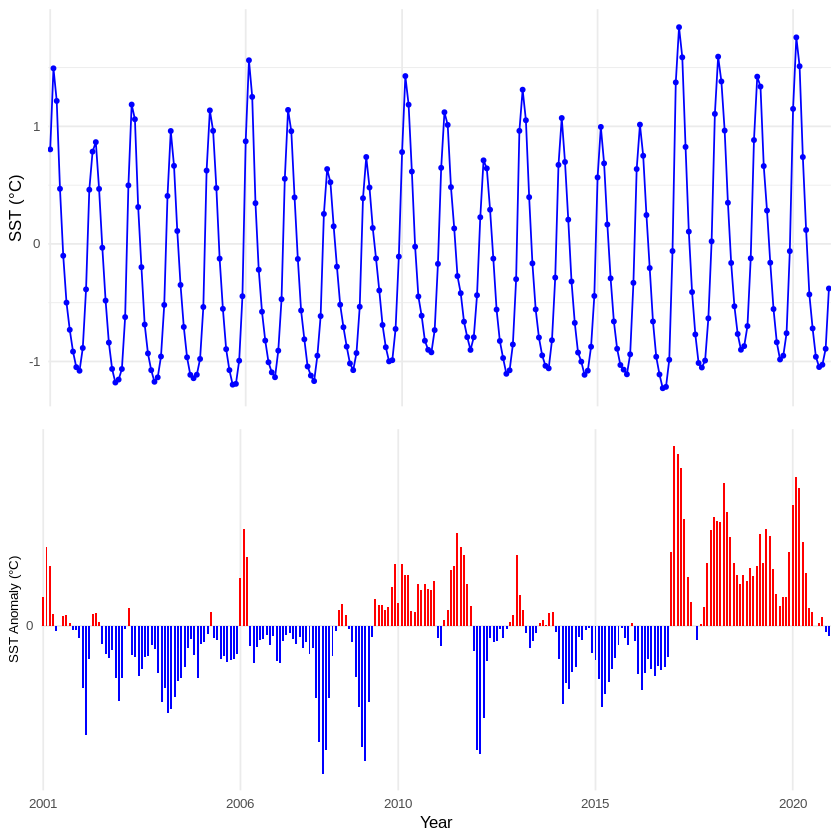

In [ ]:
library(sf)
library(terra)
library(dplyr)
library(ggplot2)
library(dplyr)
library(jsonlite)
library(gridExtra)

json_path <- "galaxy_inputs/galaxy_inputs.json"
json_data <- fromJSON(json_path)

list_year <- as.numeric(unlist(strsplit(json_data$year, ",")))
list_year_chose <- seq(list_year[1],list_year[2])
list_year <- seq(min(min(list_year_chose), 2001), max(max(list_year_chose), 2020))

subarea <- json_data$subarea 
subarea_list <- unlist(strsplit(subarea, ","))  # Convert subarea to a list

chose_list<- json_data$graphXselection

# Define the path to the GRIB data file and load it
grib_filename <- "galaxy_inputs/data/Fig5_API_8.ipynb.netcdf"
grib_raster_data <- rast(grib_filename)


n_layers <- nlyr(grib_raster_data)
chunk_size <- 10000
num_chunks <- ceiling(n_layers / chunk_size)

projected_rasters <- list()

for (i in 1:num_chunks) {
    start_layer <- (i - 1) * chunk_size + 1
    end_layer <- min(i * chunk_size, n_layers)
  
    grib_raster_chunk <- subset(grib_raster_data, start_layer:end_layer)
    grib_raster_chunk <- project(grib_raster_chunk, "EPSG:6932")
  
    projected_rasters[[i]] <- grib_raster_chunk
}

# Fusionner toutes les parties projetées

grib_raster_data <- do.call(c, projected_rasters)


# Function to download and read ASD shapefiles
download_asd_data <- function() {
  # Define output directory for downloading files
  output_dir <- "asd"
  dir.create(output_dir, showWarnings = FALSE)
  
  # URLs for the ASD shapefiles
  asd_urls <- paste0(
    "https://raw.githubusercontent.com/ccamlr/data/refs/tags/v0.5.0/geographical_data/asd/asd-shapefile-EPSG6932.",
    c("shp", "shx", "dbf", "prj", "cst")
  )
  
  # Destination file paths for saving the downloaded files
  destination_files <- file.path(output_dir, basename(asd_urls))
  
  # Download each ASD file
  mapply(download.file, asd_urls, destination_files, MoreArgs = list(mode = "wb"))
  
  # Read the shapefile into an sf object and return it
  st_read(file.path(output_dir, "asd-shapefile-EPSG6932.shp"))
}

# Download and read the ASD data
asd_data <- download_asd_data()

# Filter the ASD data for the selected subareas
selected_subareas <- filter(asd_data, GAR_Short_ %in% subarea_list)

# Crop and mask the GRIB data based on the selected subareas
selected_subareas <- vect(selected_subareas)

masked_grib_data <- grib_raster_data %>%
  crop(selected_subareas) %>%
  mask(selected_subareas)

# Convert the masked GRIB data to a dataframe for easier manipulation
grib_data_df <- as.data.frame(masked_grib_data, xy = TRUE)

# Define the number of days in each month (non-leap year)
month_days <- c(Jan = 31, Feb = 28, Mar = 31, Apr = 30, May = 31, Jun = 30,
                Jul = 31, Aug = 31, Sep = 30, Oct = 31, Nov = 30, Dec = 31)

# Function to check if a year is a leap year
is_leap_year <- function(year) {
  (year %% 4 == 0 && year %% 100 != 0) || (year %% 400 == 0)
}

# Calculate the mean position of the GRIB data for each row
grib_data_mean_position <- grib_data_df[, -c(1,2)]  # Exclude xy columns
grib_data_mean_position <- data.frame(mean_position = colMeans(grib_data_df[, -c(1,2)]))

# Initialize an empty dataframe for storing monthly means
monthly_mean_df <- data.frame()
cumulative_row_count <- 0

# Loop through each year to compute monthly means
for (year in list_year) {
  # Adjust February days for leap years
  month_days["Feb"] <- ifelse(is_leap_year(year), 29, 28)
  
  # Compute the cumulative month indices
  month_indices <- cumsum(month_days)
  month_start_indices <- c(1, head(month_indices, -1) + 1)
  
  # Create column names for each year-month combination
  year_month_names <- paste(year, names(month_days), sep = "_")
  
  # Loop through each month to calculate the mean for that month
  for (i in seq_along(year_month_names)) {
    start_idx <- (month_start_indices[i]*8) + cumulative_row_count
    end_idx <- (month_indices[i]*8) + cumulative_row_count
    
    # Compute the mean value for the current month
    mean_value <- mean(grib_data_mean_position$mean_position[start_idx:end_idx])
    
    # Add the result to the monthly mean dataframe
    monthly_mean_df <- rbind(monthly_mean_df, data.frame(
      date = year_month_names[i],
      mean_value = mean_value
    ))
  }
  # Update the cumulative row count for the next year
  cumulative_row_count <- cumulative_row_count + (month_indices[12]*8)
}

# Filter the monthly mean data for the years 2001 to 2020
filtered_monthly_mean_df <- monthly_mean_df %>%
  filter(as.numeric(substr(date, 1, 4)) >= 2001 & as.numeric(substr(date, 1, 4)) <= 2020)

# Calculate the monthly mean for each month (Jan, Feb, etc.) across the entire period
month_list <- names(month_days)
monthly_mean_by_month <- sapply(month_list, function(month) {
  mean(filtered_monthly_mean_df$mean_value[grepl(paste0("_", month), filtered_monthly_mean_df$date)], na.rm = TRUE)
}, simplify = FALSE)

# Create a dataframe with anomalies (difference from the monthly mean)
df_with_anomalies <- monthly_mean_df %>%
  mutate(
    month = substr(date, 6, 8),  # Extract the month as a 3-letter abbreviation (e.g., "Jan")
    anomaly = mean_value - sapply(month, function(m) monthly_mean_by_month[[m]])  # Calculate the anomaly
  ) %>%
  select(-month)

# Set the correct order for the dates in the plot
df_with_anomalies$date <- factor(df_with_anomalies$date, levels = unique(df_with_anomalies$date))

# Save the anomaly plot as a PNG image

# Add the year column to the dataframe for further analysis
df_with_anomalies$year <- substr(df_with_anomalies$date, 1, 4)


df_filtered_years_choose <- df_with_anomalies %>%
  filter((as.numeric(year) %in% list_year_chose))

quartiles <- quantile(as.numeric(unique(df_filtered_years_choose$year)), probs = c(0, 0.25, 0.5, 0.75, 1))
selected_years <- unique(round(quartiles))


filtered_break <- df_filtered_years_choose %>%
  filter(grepl("_Jan", date) & as.numeric(year) %in% selected_years)

# Convert the mean temperature to Celsius (from Kelvin)
df_with_anomalies_Celsius <- df_with_anomalies %>%
  mutate(mean_temperature_Celsius = mean_value - 273.15)


if (chose_list == "SST" || chose_list == "SST_SSTa") {
  anomalies_temperature <- ggplot(df_filtered_years_choose, aes(x = date, y = anomaly, fill = anomaly > 0)) +
    geom_col(width = 0.6) +
    scale_fill_manual(values = c("blue", "red")) +
    scale_x_discrete(
      breaks = filtered_break$date, 
      labels = substr(filtered_break$date, 1, 4)  # Display only the year labels
    ) +
    scale_y_continuous(
      breaks = c(-1, 0, 1),      # Les points où l'axe y aura des repères
      labels = c(-1, 0, 1)       # Les labels correspondants aux repères
    )+
    labs(x = "Year", y = "SST Anomaly (°C)") +
    theme_minimal() +
    theme(
      legend.position = "none",
      axis.title.x = element_text(size = 10),
      axis.title.y = element_text(size = 8),
      axis.text.x = element_text(size = 8),
      axis.text.y = element_text(size = 8)
    )
}

if (chose_list == "SSTa" || chose_list == "SST_SSTa") {
  temperature_plot <- ggplot(df_with_anomalies_Celsius, aes(x = date, y = mean_temperature_Celsius, group = 1)) +
    geom_line(color = "blue", size = 0.5) +
    geom_point(color = "blue", size = 1) +
    scale_x_discrete(
      breaks = filtered_break$date, 
      labels = substr(filtered_break$date, 1, 4)  # Display only the year labels
    ) +
    labs(x = "Year", y = "SST (°C)") +
    theme_minimal()+
    theme(
      legend.position = "none",
      axis.title.x = element_text(size = 10),
      axis.title.y = element_text(size = 10),
      axis.text.x = element_text(size = 8),
      axis.text.y = element_text(size = 8)
    )
}

if (chose_list == "SST_SSTa") {
  temperature_plot <- temperature_plot +
    theme(axis.text.x = element_blank(), axis.title.x = element_blank())
  
  combined_plot <- grid.arrange(temperature_plot, anomalies_temperature, nrow = 2)
  ggsave("outputs/combined_plot.png", plot = combined_plot, width = 12, height = 6, units = "in", bg = "white")
} else {
  if (chose_list == "SST") {
    ggsave("outputs/anomalies_temperature.png", plot = anomalies_temperature, width = 12, height = 3, units = "in", bg = "white")
  }
  if (chose_list == "SSTa") {
    ggsave("outputs/temperature.png", plot = temperature_plot, width = 12, height = 3, units = "in", bg = "white")
  }
}

